In [83]:
# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn + Imbalanced-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Imputers
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# Models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
                             average_precision_score, classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)


In [84]:
# Load dataset
path = "dataset_task1.csv"   
df = pd.read_csv(path)

print("Dataset Shape:", df.shape)
display(df.head())

print("\nColumn Info:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())


Dataset Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

Target column selected: Churn
Missing in TotalCharges: 11
Target was categorical. Encoded classes: ['No', 'Yes']
Train shape: (5634, 20) Test shape: (1409, 20)


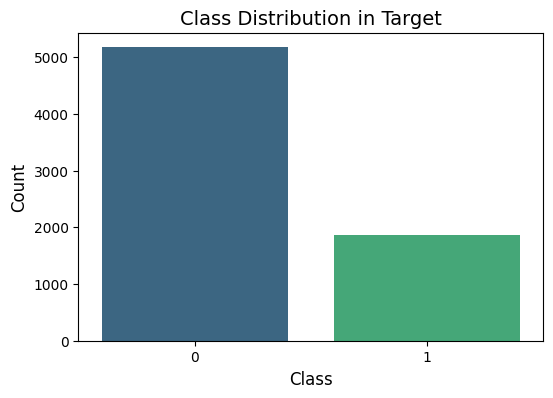

Class distribution (percentage):
 0    73.46%
1    26.54%
Name: proportion, dtype: object


In [95]:

# STEP 1: Identify Target Column

target_col = "Churn" 
print(f"Target column selected: {target_col}")

# convert TotalCharges to numeric (coerce errors) and re-run type detection
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(' ', np.nan), errors='coerce')
print("Missing in TotalCharges:", df['TotalCharges'].isna().sum())



# STEP 2: Split Features and Target
X = df.drop(columns=[target_col])   # Features
y = df[target_col]                  # Target

# STEP 3: Encode Target if Categorical
if y.dtype == "object":
    le = LabelEncoder()
    y = le.fit_transform(y)   # Example: "Yes"/"No" → 1/0
    print("Target was categorical. Encoded classes:", list(le.classes_))
else:
    print("Target is already numeric.")


# STEP 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% test, 80% train
    stratify=y,           # Keep class ratio same in train/test
    random_state=42       # For reproducibility
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


# STEP 5: Visualize Class Distribution
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(6,4))
sns.countplot(x=y, palette="viridis")  # Bar chart for class counts
plt.title("Class Distribution in Target", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


# STEP 6: Print Percentage Distribution
class_dist = pd.Series(y).value_counts(normalize=True).map("{:.2%}".format)
print("Class distribution (percentage):\n", class_dist)



Initially detected numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Initially detected categorical columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Reclassified 'SeniorCitizen' as categorical (only 2 unique values).
Final classification of features:
Numeric columns: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']


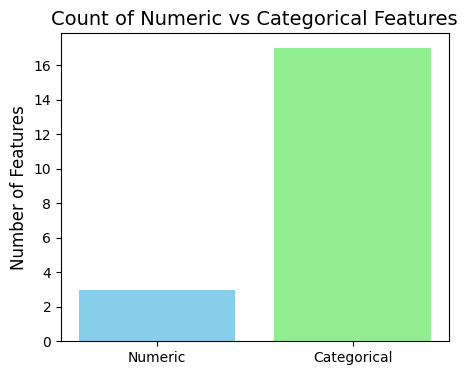

In [86]:
# STEP 1: Detect Feature Types
# Separate numeric vs categorical features
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Initially detected numeric columns:", num_cols)
print("Initially detected categorical columns:", cat_cols)


# STEP 2: Reclassify Low-Cardinality Integers
# Many integer columns are really categorical (e.g., 0/1 for Yes/No, 1-12 for months).
# We'll treat any numeric column with <=10 unique values as categorical.
for col in num_cols.copy():
    if X[col].nunique() <= 10:
        cat_cols.append(col)
        num_cols.remove(col)
        print(f"Reclassified '{col}' as categorical (only {X[col].nunique()} unique values).")

print("Final classification of features:")
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


# STEP 3: Visualize Column Types
plt.figure(figsize=(5,4))
plt.bar(["Numeric", "Categorical"], [len(num_cols), len(cat_cols)], color=["skyblue", "lightgreen"])
plt.title("Count of Numeric vs Categorical Features", fontsize=14)
plt.ylabel("Number of Features", fontsize=12)
plt.show()



In [87]:
# STEP 1: Define Numeric Pipelines
# We will experiment with multiple imputation + scaling strategies for numeric data.
# This helps us analyze how preprocessing choices affect model performance.

numeric_pipelines = {
    "mean_std": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),         # replace NaNs with column mean
        ("scaler", StandardScaler())                         # standardize (zero mean, unit variance)
    ]),
    
    "median_minmax": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),       # replace NaNs with median
        ("scaler", MinMaxScaler())                           # scale values between [0,1]
    ]),
    
    "knn_std": Pipeline([
        ("imputer", KNNImputer(n_neighbors=3)),              # impute using KNN (3 nearest neighbors)
        ("scaler", StandardScaler())
    ]),
    
    "iterative_std": Pipeline([
        ("imputer", IterativeImputer(random_state=42, max_iter=5)), # multivariate imputation
        ("scaler", StandardScaler())
    ])
}

print("Defined numeric pipelines:")
for name in numeric_pipelines.keys():
    print(f" - {name}")

# STEP 2: Define Categorical Pipeline
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),    # replace missing values with mode
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # One-hot encode
])

print("\n Defined categorical pipeline (Most Frequent Imputation + OneHot Encoding)")


Defined numeric pipelines:
 - mean_std
 - median_minmax
 - knn_std
 - iterative_std

 Defined categorical pipeline (Most Frequent Imputation + OneHot Encoding)


In [ ]:
# Build Preprocessor Function
# This function constructs a ColumnTransformer that:
# Applies the chosen numeric pipeline to numeric columns
# Applies the categorical pipeline to categorical columns
# -Drops all other columns 

def build_preprocessor(num_pipe):
    preprocessor = ColumnTransformer([
        ("num", num_pipe, num_cols),           # numeric pipeline on numeric features
        ("cat", categorical_pipeline, cat_cols) # categorical pipeline on categorical features
    ], remainder="drop")
    
    print(f"\n Preprocessor built with {num_pipe} for numeric data")
    print("   - Numeric columns processed:", num_cols)
    print("   - Categorical columns processed:", cat_cols)
    
    return preprocessor


In [ ]:
# STEP 1: Define Numeric Pipelines
# We will experiment with multiple imputation + scaling strategies for numeric data.
# This helps us analyze how preprocessing choices affect model performance.

numeric_pipelines = {
    "mean_std": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),         # replace NaNs with column mean
        ("scaler", StandardScaler())                         # standardize (zero mean, unit variance)
    ]),
    
    "median_minmax": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),       # replace NaNs with median
        ("scaler", MinMaxScaler())                           # scale values between [0,1]
    ]),
    
    "knn_std": Pipeline([
        ("imputer", KNNImputer(n_neighbors=3)),              # impute using KNN (3 nearest neighbors)
        ("scaler", StandardScaler())
    ]),
    
    "iterative_std": Pipeline([
        ("imputer", IterativeImputer(random_state=42, max_iter=5)), # multivariate imputation
        ("scaler", StandardScaler())
    ])
}

print("Defined numeric pipelines:")
for name in numeric_pipelines.keys():
    print(f" - {name}")

# STEP 2: Define Categorical Pipeline
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),    # replace missing values with mode
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # One-hot encode
])

print("\n Defined categorical pipeline (Most Frequent Imputation + OneHot Encoding)")


Defined numeric pipelines:
 - mean_std
 - median_minmax
 - knn_std
 - iterative_std

 Defined categorical pipeline (Most Frequent Imputation + OneHot Encoding)


In [89]:
# STEP 1: Define Model Runner

def run_model(numeric_pipe, model, use_smote=True):
    """
    Build a preprocessing + modeling pipeline, train, evaluate, and visualize.
    
    Parameters:
    -----------
    numeric_pipe : sklearn Pipeline
        Numeric preprocessing pipeline (imputer + scaler)
    model : sklearn estimator
        Classifier to train
    use_smote : bool
        Whether to apply SMOTE for class imbalance handling
    
    
    """
    
    # Build preprocessor for numeric + categorical features
    preprocessor = build_preprocessor(numeric_pipe)

    # Choose pipeline type (with or without SMOTE)
    if use_smote:
        pipe = ImbPipeline([
            ("pre", preprocessor),
            ("smote", SMOTE(random_state=42)),
            ("clf", model)
        ])
        print("Using SMOTE for class imbalance.")
    else:
        pipe = Pipeline([
            ("pre", preprocessor),
            ("clf", model)
        ])
        print("Not using SMOTE.")

    # Fit model
    print("\n Training model...")
    pipe.fit(X_train, y_train)
    print("Model trained successfully.")

    # Predictions
    y_pred = pipe.predict(X_test)

    # Basic metrics
    results = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0)
    }

    # Print classification report
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion matrix
    from sklearn.metrics import ConfusionMatrixDisplay

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", normalize="true")
    plt.title("Confusion Matrix (Normalized)")
    plt.show()

    # If model supports probabilities → ROC + PR
    if hasattr(pipe["clf"], "predict_proba"):
        y_proba = pipe.predict




 Running RandomForest with preprocessing: mean_std

 Preprocessor built with Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]) for numeric data
   - Numeric columns processed: ['tenure', 'MonthlyCharges', 'TotalCharges']
   - Categorical columns processed: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
Using SMOTE for class imbalance.

 Training model...
Model trained successfully.

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



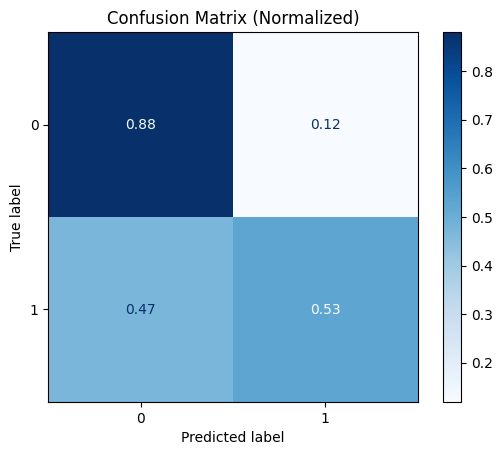


 Running RandomForest with preprocessing: median_minmax

 Preprocessor built with Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler())]) for numeric data
   - Numeric columns processed: ['tenure', 'MonthlyCharges', 'TotalCharges']
   - Categorical columns processed: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
Using SMOTE for class imbalance.

 Training model...
Model trained successfully.

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.61      0.55      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0

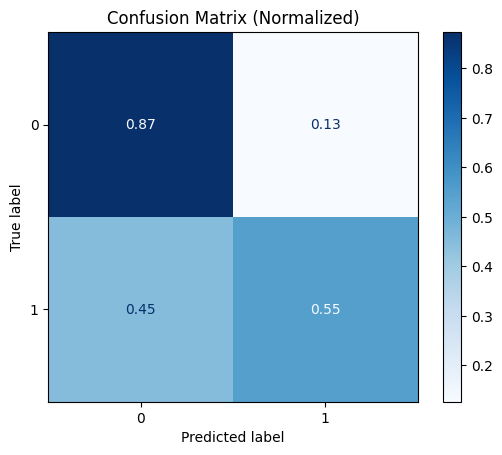


 Running RandomForest with preprocessing: knn_std

 Preprocessor built with Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler())]) for numeric data
   - Numeric columns processed: ['tenure', 'MonthlyCharges', 'TotalCharges']
   - Categorical columns processed: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
Using SMOTE for class imbalance.

 Training model...
Model trained successfully.

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.78      0.

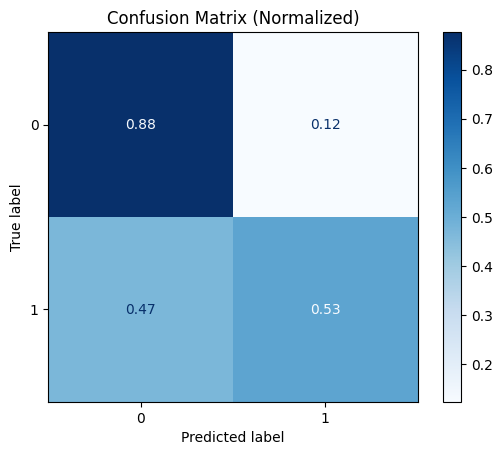


 Running RandomForest with preprocessing: iterative_std

 Preprocessor built with Pipeline(steps=[('imputer', IterativeImputer(max_iter=5, random_state=42)),
                ('scaler', StandardScaler())]) for numeric data
   - Numeric columns processed: ['tenure', 'MonthlyCharges', 'TotalCharges']
   - Categorical columns processed: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
Using SMOTE for class imbalance.

 Training model...
Model trained successfully.

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.60      0.55      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg   

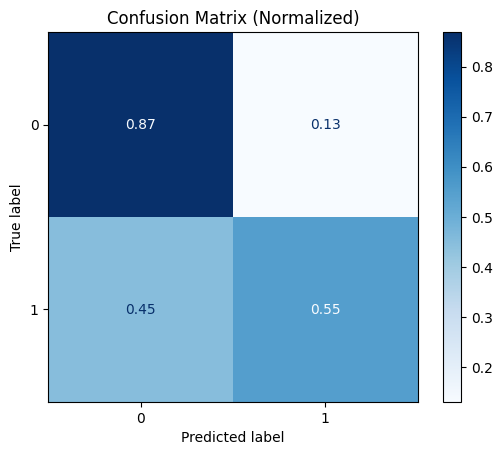

In [ ]:
# STEP: Run Experiments with Different Preprocessing


# 1. Define the model
rf = RandomForestClassifier(
    n_estimators=100,   # number of trees
    random_state=42,    # reproducibility
    n_jobs=-1           # use all CPU cores
)

# 2. Dictionary to store results
experiment_results = {}

# 3. Run experiments for each numeric pipeline
for name, num_pipe in numeric_pipelines.items():
    print(f"\n Running RandomForest with preprocessing: {name}")
    experiment_results[name] = run_model(num_pipe, rf, use_smote=True)





CV testing pipeline: mean_std

 Preprocessor built with Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]) for numeric data
   - Numeric columns processed: ['tenure', 'MonthlyCharges', 'TotalCharges']
   - Categorical columns processed: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
  F1 scores: [0.54964539 0.55197133 0.58318426 0.55789474 0.59217877]

CV testing pipeline: median_minmax

 Preprocessor built with Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler())]) for numeric data
   - Numeric columns processed: ['tenure', 'MonthlyCharges', 'TotalCharges']
   - Categorical columns processed: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetSer

,f1_mean,f1_std
mean_std,0.566975,0.017354
median_minmax,0.572735,0.016579
knn_std,0.568019,0.014140
iterative_std,0.562380,0.012504


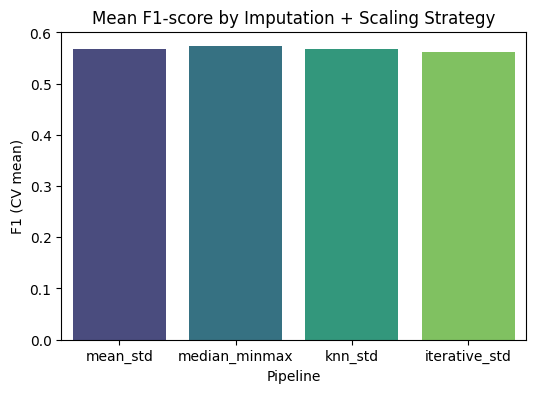

In [91]:
# Compare Imputation + Scaling Strategies (WITH SMOTE inside CV)


from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Define the base model (RandomForest)
rf = RandomForestClassifier(
    n_estimators=100,  # number of trees
    random_state=42,   # reproducibility
    n_jobs=-1          # use all CPU cores
)

# 5-fold Stratified CV (keeps class balance in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to collect results for each numeric preprocessing pipeline
imputer_comparison = {}

# Loop through each numeric preprocessing strategy (mean, median, knn, iterative)
for name, num_pipe in numeric_pipelines.items():
    print(f"\nCV testing pipeline: {name}")
    
    # Build preprocessing transformer (numeric + categorical handling)
    pre = build_preprocessor(num_pipe)
    
    # Build pipeline with:
    # 1. Preprocessing
    # 2. SMOTE (resampling INSIDE CV fold to prevent leakage)
    # 3. RandomForest classifier
    pipe = ImbPipeline([
        ("pre", pre),
        ("smote", SMOTE(random_state=42, k_neighbors=1)),
        ("clf", rf)
    ])
    
    # Perform cross-validation using F1-score
    f1_scores = cross_val_score(
        pipe, X_train, y_train, 
        cv=cv, scoring="f1", n_jobs=-1
    )
    
    print(f"  F1 scores: {f1_scores}")
    
    # Store mean and std of F1 for later comparison
    imputer_comparison[name] = {
        "f1_mean": np.mean(f1_scores),
        "f1_std": np.std(f1_scores)
    }

# Convert dictionary to DataFrame for easier viewing
imputer_results = pd.DataFrame(imputer_comparison).T
display(imputer_results)


# Visualization
plt.figure(figsize=(6,4))
sns.barplot(
    data=imputer_results.reset_index(),
    x="index", y="f1_mean", palette="viridis"
)
plt.title("Mean F1-score by Imputation + Scaling Strategy")
plt.ylabel("F1 (CV mean)")
plt.xlabel("Pipeline")
plt.show()


In [ ]:
# Bagging and Boosting Experiments

# Define models
# Bagging: Ensemble of Decision Trees
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=30,       # number of trees in the bag
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

# AdaBoost: Sequential boosting of weak learners
ada = AdaBoostClassifier(
    n_estimators=50,       # number of weak learners
    random_state=42
)

# Histogram-based Gradient Boosting: efficient boosting for tabular data
hgb = HistGradientBoostingClassifier(
    max_iter=50,           # number of boosting iterations
    random_state=42
)

# Bundle models in a dictionary for iteration
models = {
    "Bagging": bag,
    "AdaBoost": ada,
    "HistGradientBoosting": hgb
}


# Train + Evaluate each model

bb_results = {}

for name, model in models.items():
    print(f"\n Training {name}...")
    
    # Build preprocessing pipeline (mean imputation + standardization for numeric features)
    pre = build_preprocessor(numeric_pipelines["mean_std"])
    
    # Full pipeline = Preprocessor + Model
    pipe = Pipeline([
        ("pre", pre),
        ("clf", model)
    ])
    
    # Train on training set
    pipe.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = pipe.predict(X_test)
    
    # Collect evaluation metrics
    bb_results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0)
    }

# Convert results to DataFrame for comparison
bb_df = pd.DataFrame(bb_results).T
display(bb_df)




 Training Bagging...

 Preprocessor built with Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]) for numeric data
   - Numeric columns processed: ['tenure', 'MonthlyCharges', 'TotalCharges']
   - Categorical columns processed: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

 Training AdaBoost...

 Preprocessor built with Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]) for numeric data
   - Numeric columns processed: ['tenure', 'MonthlyCharges', 'TotalCharges']
   - Categorical columns processed: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', '

,accuracy,precision,recall,f1
Bagging,0.794180,0.640940,0.510695,0.568452
AdaBoost,0.800568,0.643077,0.558824,0.597997
HistGradientBoosting,0.796309,0.643564,0.521390,0.576071


In [93]:
# LDA & QDA with PCA


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report


# Step 1: Preprocess the data
# Use mean imputation + standardization for numeric, and one-hot for categorical
pre = build_preprocessor(numeric_pipelines["mean_std"])

# Apply preprocessing to train and test data
X_train_trans = pre.fit_transform(X_train, y_train)
X_test_trans = pre.transform(X_test)

# Step 2: Dimensionality Reduction with PCA
# Keep at most 50 principal components (or limited by features/samples)
n_components = min(50, X_train_trans.shape[1], X_train_trans.shape[0]-1)

pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_trans)
X_test_pca = pca.transform(X_test_trans)

# Step 3: Train and Evaluate LDA
lda = LinearDiscriminantAnalysis(
    solver="lsqr",         # supports shrinkage
    shrinkage="auto"       # regularized LDA to prevent overfitting
)

lda.fit(X_train_pca, y_train)
y_pred_lda = lda.predict(X_test_pca)

print("LDA Report:")
print(classification_report(y_test, y_pred_lda))


# Step 4: Train and Evaluate QDA
qda = QuadraticDiscriminantAnalysis(
    reg_param=0.1          # regularization parameter for stability
)

qda.fit(X_train_pca, y_train)
y_pred_qda = qda.predict(X_test_pca)

print("\n QDA Report:")
print(classification_report(y_test, y_pred_qda))




 Preprocessor built with Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]) for numeric data
   - Numeric columns processed: ['tenure', 'MonthlyCharges', 'TotalCharges']
   - Categorical columns processed: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
LDA Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409


 QDA Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.52      0.77 

In [94]:
# Hyperparameter Tuning with GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Step 1: Build pipeline
# - Preprocess numeric (impute + scale) and categorical (one-hot)
# - Apply SMOTE inside CV folds to avoid data leakage
# - Train RandomForest as classifier
pipe = ImbPipeline([
    ("pre", build_preprocessor(numeric_pipelines["mean_std"])),
    ("smote", SMOTE(random_state=42, k_neighbors=1)),   # SMOTE applied inside CV
    ("clf", RandomForestClassifier(random_state=42))
])

# Step 2: Define Hyperparameter Grid
# We tune two main parameters:
# - n_estimators: number of trees
# - max_depth: how deep each tree can grow
param_grid = {
    "clf__n_estimators": [50, 100],   # try 50 and 100 trees
    "clf__max_depth": [None, 6, 12]   # None = unlimited depth, or restrict to 6/12 levels
}


# Step 3: Grid Search with Cross-Validation
# - Uses 3-fold CV
# - Optimizes for F1-score (better for imbalanced data than accuracy)
# - Runs in parallel with n_jobs=-1
gs = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# Train across all parameter combinations
gs.fit(X_train, y_train)


# Step 4: Best Model and Results
print("Best params found:", gs.best_params_)
print("Best mean CV F1-score:", gs.best_score_)

# Step 5: Evaluate Best Model on Test Set
best_model = gs.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\n Test Set Classification Report (Best RandomForest):")
print(classification_report(y_test, y_pred_best))




 Preprocessor built with Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]) for numeric data
   - Numeric columns processed: ['tenure', 'MonthlyCharges', 'TotalCharges']
   - Categorical columns processed: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params found: {'clf__max_depth': 12, 'clf__n_estimators': 100}
Best mean CV F1-score: 0.6259670674243861

 Test Set Classification Report (Best RandomForest):
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
